In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
import random
import hashlib
from PIL import Image
import albumentations as A
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from transformers import TFSegformerForSemanticSegmentation
from transformers import create_optimizer
import torch
import numpy as np
from diffusers.utils import load_image, make_image_grid
import torch
from torchvision.transforms.functional import to_pil_image
from PIL import Image
import cv2
from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import copy
from diffusers import StableDiffusionInpaintPipeline, EulerDiscreteScheduler


2024-07-21 23:44:32.601804: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-21 23:44:32.601905: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-21 23:44:32.644237: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-21 23:44:32.739113: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-21 23:44:34.094289: W tensorflow/compiler/tf2

In [2]:
pwd

'/mnt/c/Users/Lenovo'

In [3]:
im_path = "/mnt/c/Users/Lenovo/Desktop/DS/Datasets/PeopleClothing/png_images/IMAGES/"
anno_path = "/mnt/c/Users/Lenovo/Desktop/DS/Datasets/PeopleClothing/png_masks/MASKS/"
val_im_path = "/mnt/c/Users/Lenovo/Desktop/DS/Datasets/PeopleClothing/val_png_images/IMAGES/"
val_anno_path = "/mnt/c/Users/Lenovo/Desktop/DS/Datasets/PeopleClothing/val_png_masks/MASKS/"

In [4]:
# val_list=["0025","0010","0003","0125","0200","0515","0225","0805","0915","0630","0301","0112","0905","0823","0527","0088","0055","0018",
#           "0222","0049","0273","0299","0282","0372","0027","0445","0582","0374","0956","0211","0019","0961","0397","0699","0789","0996","0290",
#           "0110","0315","0335","0419","0666","0525","0927","0555","0275","0855","0815","0130","0371","0412","0105","0423","0507","0028","0035","0118",
#           "0232","0849","0673","0688","0777","0472","0991","0485","0592","0334","0827","0651","0619","0567","0393","0609","0719","0916","0190",
#           ]

In [5]:
# import shutil
# for name in val_list:
#   shutil.move(im_path+"img_"+name+".png", val_im_path+"img_"+name+".png")
#   shutil.move(anno_path+"seg_"+name+".png", val_anno_path+"seg_"+name+".png")

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    ([im_path+i for i in os.listdir(im_path)],
    [anno_path+"seg"+i[3:] for i in os.listdir(im_path)])
)
val_dataset = tf.data.Dataset.from_tensor_slices(
    ([val_im_path+i for i in os.listdir(val_im_path)],
    [val_anno_path+"seg"+i[3:] for i in os.listdir(val_im_path)])
)

2024-07-21 23:44:42.908594: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-21 23:44:42.914474: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-21 23:44:42.914555: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-21 23:44:42.919057: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-21 23:44:42.919137: I external/local_xla/xla/stream_executor

In [7]:
for i in train_dataset.take(3):
  print(i)

(<tf.Tensor: shape=(), dtype=string, numpy=b'/mnt/c/Users/Lenovo/Desktop/DS/Datasets/PeopleClothing/png_images/IMAGES/img_0001.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/mnt/c/Users/Lenovo/Desktop/DS/Datasets/PeopleClothing/png_masks/MASKS/seg_0001.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/mnt/c/Users/Lenovo/Desktop/DS/Datasets/PeopleClothing/png_images/IMAGES/img_0002.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/mnt/c/Users/Lenovo/Desktop/DS/Datasets/PeopleClothing/png_masks/MASKS/seg_0002.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/mnt/c/Users/Lenovo/Desktop/DS/Datasets/PeopleClothing/png_images/IMAGES/img_0004.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/mnt/c/Users/Lenovo/Desktop/DS/Datasets/PeopleClothing/png_masks/MASKS/seg_0004.png'>)


In [8]:
for i in val_dataset.take(3):
  print(i)

(<tf.Tensor: shape=(), dtype=string, numpy=b'/mnt/c/Users/Lenovo/Desktop/DS/Datasets/PeopleClothing/val_png_images/IMAGES/img_0003.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/mnt/c/Users/Lenovo/Desktop/DS/Datasets/PeopleClothing/val_png_masks/MASKS/seg_0003.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/mnt/c/Users/Lenovo/Desktop/DS/Datasets/PeopleClothing/val_png_images/IMAGES/img_0010.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/mnt/c/Users/Lenovo/Desktop/DS/Datasets/PeopleClothing/val_png_masks/MASKS/seg_0010.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/mnt/c/Users/Lenovo/Desktop/DS/Datasets/PeopleClothing/val_png_images/IMAGES/img_0018.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/mnt/c/Users/Lenovo/Desktop/DS/Datasets/PeopleClothing/val_png_masks/MASKS/seg_0018.png'>)


## Preprocessing

In [9]:
#Values obtained from imagenet dataset
MEAN = [123.675, 116.28, 103.53]
STD = [58.395, 57.12, 57.375]


In [10]:
def preprocess(im_path, anno_path):
  img = tf.io.decode_jpeg(tf.io.read_file(im_path))
  img = tf.cast(img,tf.float32)
  img = (img-MEAN)/STD

  anno = tf.io.decode_jpeg(tf.io.read_file(anno_path))
  anno = tf.cast(tf.squeeze(anno,-1),tf.float32)

  return img, anno

In [11]:
prep_train_ds = (
    train_dataset
    .map(preprocess,num_parallel_calls=tf.data.AUTOTUNE)
)
prep_val_ds = (
    val_dataset
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
)

In [12]:
for i,j in prep_train_ds.take(1):
  print(i.shape,j.shape)

(825, 550, 3) (825, 550)


## Augmentation

In [13]:
H,W = 512,512

In [14]:
transform = A.Compose([
    A.RandomCrop (H,W, p=1.0),
    A.HorizontalFlip(p=0.3),
    A.VerticalFlip(p=0.3),
    A.RandomRotate90(p=0.3),
    A.Transpose(p=0.3),
    A.Sharpen (alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=0.1),
    A.RandomShadow (shadow_roi=(0, 0.5, 1, 1),
                    num_shadows_lower=1, num_shadows_upper=2,
                    shadow_dimension=5, p=0.1),
    A.RandomBrightnessContrast(p=0.2),
])

val_transform = A.Compose([
    A.Resize(H,W),
])

In [15]:
def aug_albument(image,mask):
  augmented = transform(image=image, mask=mask)
  return [tf.convert_to_tensor(augmented["image"],dtype=tf.float32),
          tf.convert_to_tensor(augmented["mask"], dtype=tf.float32)]
def val_aug_albument(image,mask):
  augmented = val_transform(image=image, mask=mask)
  return [tf.convert_to_tensor(augmented["image"],dtype=tf.float32),
          tf.convert_to_tensor(augmented["mask"], dtype=tf.float32)]

In [16]:
def augment(image,mask):
  aug_output = tf.numpy_function(func=aug_albument, inp=[image,mask], Tout=[tf.float32,tf.float32])
  return {"pixel_values":tf.transpose(aug_output[0],(2,0,1)), "labels":aug_output[1]}

def val_augment(image,mask):
  aug_output = tf.numpy_function(func=val_aug_albument, inp=[image,mask], Tout=[tf.float32,tf.float32])
  return {"pixel_values":tf.transpose(aug_output[0],(2,0,1)), "labels":aug_output[1]}


In [17]:
BATCH_SIZE = 2
train_ds = (
    prep_train_ds
    .shuffle(10)
    .map(augment,num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
val_ds = (
    prep_val_ds
    .map(val_augment,num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [18]:
for i in train_ds.take(1):
  print(i)

{'pixel_values': <tf.Tensor: shape=(2, 3, 512, 512), dtype=float32, numpy=
array([[[[ 0.94394124,  1.1711631 ,  0.4970906 , ...,  0.07685332,
           0.18666789,  0.3785369 ],
         [ 0.88376796,  0.9287956 ,  0.8560082 , ...,  0.06591272,
           0.19760847,  0.40041804],
         [ 1.0550215 ,  1.1808385 ,  1.0394672 , ...,  0.0810582 ,
           0.12228972,  0.27166176],
         ...,
         [ 1.0684927 ,  0.99864423,  1.0466113 , ...,  0.6784673 ,
           0.7264346 ,  0.7209643 ],
         [ 0.9944392 ,  0.72598606,  0.86021286, ...,  0.78534234,
           0.77440166,  0.7689314 ],
         [ 0.9313267 ,  0.8505378 ,  0.8189812 , ...,  0.77440166,
           0.75252056,  0.68814254]],

        [[ 1.0949957 ,  1.3272895 ,  0.6493554 , ..., -0.2714365 ,
          -0.15917076,  0.03698107],
         [ 1.0334793 ,  1.0795125 ,  1.0274692 , ..., -0.28262132,
          -0.14798597,  0.05935067],
         [ 1.2085552 ,  1.3371803 ,  1.2038385 , ..., -0.26713783,
          

## Visualisation

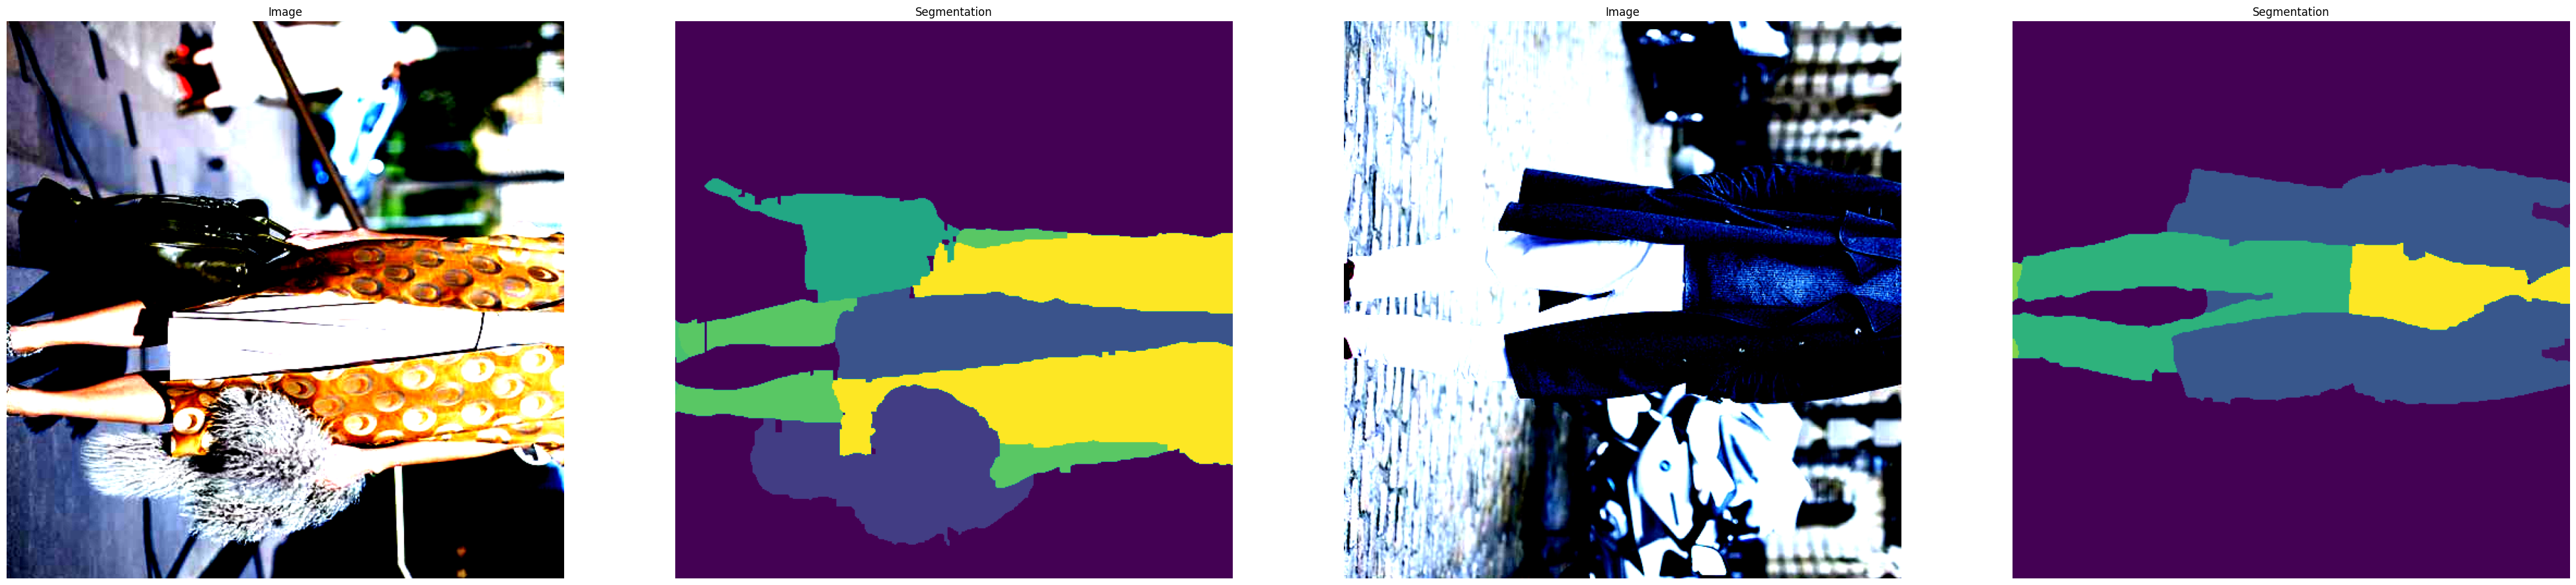

In [19]:
plt.figure(figsize = (50,50))

for data in train_ds.take(1):
  images=data['pixel_values']
  labels=data['labels']
  for i in range(BATCH_SIZE*2):
    if i==4:
      break
    ax = plt.subplot(1,BATCH_SIZE*2, i+1)
    if i%2==0:
      plt.imshow(tf.transpose(images[i//2], (1, 2, 0)))
      plt.title("Image")
    else:
      plt.imshow(labels[i//2])
      plt.title("Segmentation")
    plt.axis("off")
  plt.show()

## Modelling

In [20]:
df = pd.read_csv("/mnt/c/Users/Lenovo/Desktop/DS/Datasets/PeopleClothing/labels.csv")

In [21]:
id2label = {}
for i,j in df.iterrows():
  if i==0:
    id2label[i] = 'nan'
  else:
    id2label[i] = j['label_list']

In [22]:
label2id = {label: id for id,label in id2label.items()}

In [31]:
model_id = "nvidia/segformer-b1-finetuned-cityscapes-1024-1024"
model = TFSegformerForSemanticSegmentation.from_pretrained(
    model_id,
    num_labels = len(label2id),
    id2label = id2label,
    label2id = label2id,
    ignore_mismatched_sizes = True)

config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/55.0M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFSegformerForSemanticSegmentation.

Some weights of TFSegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b1-finetuned-cityscapes-1024-1024 and are newly initialized because the shapes did not match:
- decode_head/classifier/kernel:0: found shape (1, 1, 256, 19) in the checkpoint and (1, 1, 256, 59) in the model instantiated
- decode_head/classifier/bias:0: found shape (19,) in the checkpoint and (59,) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
model.summary()

Model: "tf_segformer_for_semantic_segmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 segformer (TFSegformerMain  multiple                  24196288  
 Layer)                                                          
                                                                 
 decode_head (TFSegformerDe  multiple                  3197243   
 codeHead)                                                       
                                                                 
Total params: 27393531 (104.50 MB)
Trainable params: 27391995 (104.49 MB)
Non-trainable params: 1536 (6.00 KB)
_________________________________________________________________


## Training

In [25]:
batch_size = 2
num_epochs = 10
num_train_steps = len(train_ds) * num_epochs
learning_rate = 6e-5
weight_decay_rate = 0.01

optimizer, lr_schedule = create_optimizer(
    init_lr=learning_rate,
    num_train_steps=num_train_steps,
    weight_decay_rate=weight_decay_rate,
    num_warmup_steps=0,
)

In [26]:
import evaluate
metric = evaluate.load("mean_iou")

INFO:datasets:PyTorch version 2.3.1 available.
INFO:datasets:TensorFlow version 2.15.0 available.


In [27]:
def compute_metrics(eval_pred):
  logits, labels = eval_pred
  #Model gives output in form (batch, Number of classes, h, w)
  #iou requires in the format (batch, h, w, Number of classes)
  logits = tf.transpose(logits, perm=[0,2,3,1])
  #required output is in form 512x512 ([1:] is done to exlcude batch size)
  logits_resized =tf.image.resize(
      logits,
      size=tf.shape(labels)[1:],
      method="bilinear"
  )
  #argmax to get class with highest prob
  pred_labels = tf.argmax(logits_resized, axis=-1)

  metrics = metric.compute(
      predictions = pred_labels,
      references = labels,
      num_labels = len(label2id),
      ignore_index = 0,
  )

  per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
  per_category_iou = metrics.pop("per_category_iou").tolist()

  metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
  metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})

  return {"val_" + k: v for k, v in metrics.items()}

In [28]:
from transformers.keras_callbacks import KerasMetricCallback

metric_callback = KerasMetricCallback(
    metric_fn=compute_metrics,
    eval_dataset=val_ds,
    batch_size=batch_size,
    label_cols=["labels"]
)
callbacks = [metric_callback]

In [32]:
model.compile(optimizer = optimizer)

In [33]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=num_epochs,
    # callbacks=callbacks,
    verbose =1
)

Epoch 1/10


2024-07-21 23:57:08.375358: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape intf_segformer_for_semantic_segmentation_1/decode_head/dropout_73/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


462/462 [==============================] - 114s 212ms/step - loss: 1.2045 - val_loss: 0.6574
Epoch 2/10
462/462 [==============================] - 98s 210ms/step - loss: 0.8820 - val_loss: 0.5773
Epoch 3/10
462/462 [==============================] - 98s 213ms/step - loss: 0.7904 - val_loss: 0.5306
Epoch 4/10
462/462 [==============================] - 101s 218ms/step - loss: 0.7415 - val_loss: 0.4910
Epoch 5/10
462/462 [==============================] - 101s 219ms/step - loss: 0.7077 - val_loss: 0.4785
Epoch 6/10
462/462 [==============================] - ETA: 0s - loss: 0.6756

2024-07-22 00:07:06.609681: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 10456576 bytes after encountering the first element of size 10456576 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


462/462 [==============================] - 102s 221ms/step - loss: 0.6756 - val_loss: 0.4667
Epoch 7/10
462/462 [==============================] - ETA: 0s - loss: 0.6588

2024-07-22 00:08:50.064515: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 10456576 bytes after encountering the first element of size 10456576 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


462/462 [==============================] - 103s 223ms/step - loss: 0.6588 - val_loss: 0.4645
Epoch 8/10
462/462 [==============================] - ETA: 0s - loss: 0.6457

2024-07-22 00:10:34.347225: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 10456576 bytes after encountering the first element of size 10456576 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


462/462 [==============================] - 104s 225ms/step - loss: 0.6457 - val_loss: 0.4660
Epoch 9/10
462/462 [==============================] - ETA: 0s - loss: 0.6327

2024-07-22 00:12:18.636813: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 10456576 bytes after encountering the first element of size 10456576 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


462/462 [==============================] - 104s 225ms/step - loss: 0.6327 - val_loss: 0.4644
Epoch 10/10
462/462 [==============================] - 109s 235ms/step - loss: 0.6237 - val_loss: 0.4656


In [35]:
model.save_weights('/mnt/c/Users/Lenovo/Desktop/DS/Datasets/Outputs')


In [36]:
model.load_weights('/mnt/c/Users/Lenovo/Desktop/DS/Datasets/Outputs')

## Sample generation

In [37]:
def generate_inputs(im_path, mask_label):
  mask_id = label2id[mask_label]
  source_image = cv2.imread(im_path)

  img = tf.io.decode_jpeg(tf.io.read_file(im_path))
  img = tf.image.resize(img, (H_resized, W_resized))
  img = tf.cast(img, tf.float32)
  img = (img-MEAN)/STD
  img = tf.transpose(img, (2,0,1))
  img = tf.expand_dims(img, axis=0)

  output = model(img).logits

  output = tf.argmax(output, axis=1)

  resized_output = tf.image.resize(
      tf.expand_dims(output,axis=-1),(H_init, W_init), method="bilinear", antialias=True)
  resized_output = tf.cast(tf.squeeze(resized_output, axis=-1),dtype=tf.uint8)[0].numpy()
  mask = resized_output+(-mask_id*np.ones_like(resized_output))
  #To get only the required region of the mask, we multiply all ele of the mask byitself, so the ele 0 (req part) stays same
  # we then multiply it by a high value and clip it to 255, so all non req part is 255 and req remains 0
  #subtract 255 so the req part is in white whereas rest are black
    
  mask = 255-np.clip(1e10*np.multiply(mask,mask),a_min=0, a_max=255)
  cv2.imwrite("mask.jpg", mask)

  return Image.fromarray(source_image), Image.fromarray(mask)

In [38]:
from diffusers import StableDiffusionInpaintPipeline
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
)
pipe.to("cuda")
pipe.enable_xformers_memory_efficient_attention()

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


model_index.json:   0%|          | 0.00/544 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/914 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

ModuleNotFoundError: Refer to https://github.com/facebookresearch/xformers for more information on how to install xformers

In [39]:
H_resized,W_resized = 512,512
H_init,W_init = 825,550

  0%|          | 0/50 [00:00<?, ?it/s]

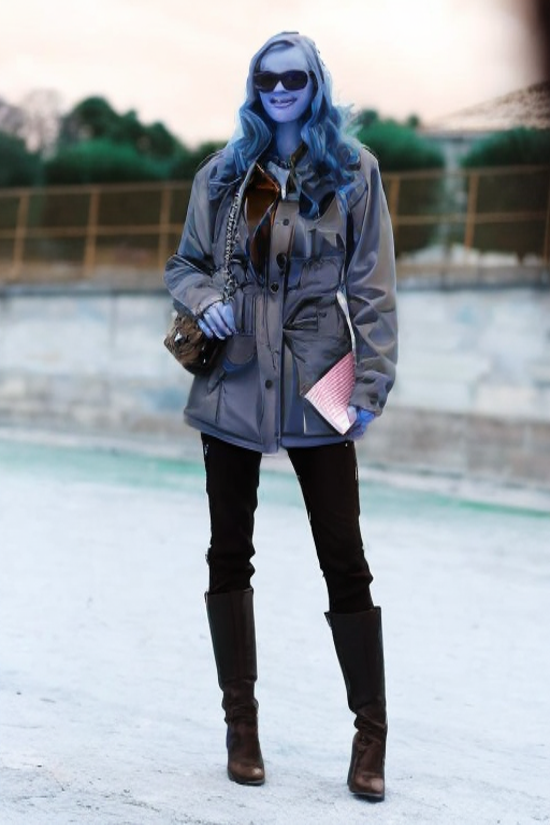

In [40]:
prompt = "A photorealistic photo of a woman wearing a green-colored nice looking coat all green high resolution"
#image and mask_image should be PIL images.
#The mask structure is white for inpainting and black for keeping as is
image, mask_image = generate_inputs(
    "/mnt/c/Users/Lenovo/Desktop/DS/Datasets/PeopleClothing/val_png_images/IMAGES/img_0003.png","coat")

image = pipe(prompt=prompt, image=image, mask_image=mask_image, ).images[0]
image.resize((W_init, H_init))
display(image.resize((550,825)))